In [1]:
!pip install pennylane
!pip install pennylane pennylane-lightning[gpu]

### Import libraries

In [2]:
import pennylane as qml
from pennylane.templates import QFT
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from skimage.transform import resize

from keras.datasets import mnist

### Dataset Preparation

* Load MIST dataset - 0/1 pixel intensities
* Reduce image to 8x8
    * Resizing using skimage
    * Crop and pad (zero-padding)
* Normalize all images:
  8x8 image -> flatten -> vector of length 64 -> normalize
* Train/Test split

In [3]:
# loading mnist from openML
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist['data'].astype(np.uint8)
y = mnist['target'].astype(np.uint8)

In [4]:
# focus on binary classification
mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]
X.shape

(14780, 784)

In [5]:
n_samples = 6000 # restricting to 6000 samples for now

X = X[:n_samples]
y = y[:n_samples]

Binarising (makes amplitude preparation stable and simplifies qjpeg vectorization)

In [6]:
X_bin = (X > 127).astype(np.uint8)
X_bin = np.array(X_bin)
X_bin.shape

(6000, 784)

Reducing images to 8x8 + flattening to (, 64)

In [7]:
# convert each 28x28 binarised image to 8x8, then flatten to length 64

def to_8x8_vector(img_row):
    img_2d = np.array(img_row).reshape(28, 28).astype(float)        # reshape flat 784 -> 28x28
    img_8x8 = resize(
        img_2d,
        (8, 8),
        anti_aliasing=False,
        preserve_range=True
    )
    return img_8x8.flatten()   # shape (64,)

# apply to all images
X_8x8 = np.array([to_8x8_vector(x) for x in X_bin], dtype=float)
X_8x8.shape

(6000, 64)

L2-normalization of the vectors:

In [8]:
def safe_l2_normalize_rows(X):
    X = X.astype(float)
    Xn = np.zeros_like(X, dtype=float)

    norms = np.linalg.norm(X, axis=1)
    for i, norm in enumerate(norms):
        if norm == 0:
            Xn[i, 0] = 1.0  # fallback to |0...0> amplitude state
        else:
            Xn[i] = X[i] / norm
    return Xn

X_8x8_norm = safe_l2_normalize_rows(X_8x8)
print("Any NaNs?", np.isnan(X_8x8_norm).any())
print("Norm check:", np.min(np.linalg.norm(X_8x8_norm, axis=1)),
      np.max(np.linalg.norm(X_8x8_norm, axis=1)))

Any NaNs? False
Norm check: 0.9999999999999998 1.0000000000000002


In [9]:
X_8x8_norm.shape

(6000, 64)

I'm gonna do the splitting here, and carry both representations consistently

In [10]:
from sklearn.model_selection import train_test_split

idx = np.arange(n_samples)

idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y, test_size=0.2, random_state=42, stratify=y
)

# QEK inputs (8x8 → 64 → normed)
X_train_qek = X_8x8_norm[idx_train]
X_test_qek  = X_8x8_norm[idx_test]

# QJPEG inputs (28x28 binary images)
X_train_img = X_bin[idx_train]
X_test_img  = X_bin[idx_test]

print("QEK train/test:", X_train_qek.shape, X_test_qek.shape)
print("IMG train/test:", X_train_img.shape, X_test_img.shape)
print("Labels train/test:", y_train.shape, y_test.shape)


QEK train/test: (4800, 64) (1200, 64)
IMG train/test: (4800, 784) (1200, 784)
Labels train/test: (4800,) (1200,)


Data preparation is done.

In [11]:
# original test states
states_test_orig = X_test_qek.copy()

### Quantum Emebdding & Kernel Training
  

In [12]:
n_qubits = 6
wires = list(range(n_qubits))

dev = qml.device("lightning.qubit", wires=wires, shots=None)

Defining QEK circuit

In [13]:
def qek_circuit(x, theta):
    """
    Quantum Embedding Kernel circuit U(x; theta)
    """
    layers = theta.shape[0]

    # Encode classical data
    qml.AmplitudeEmbedding(x, wires=range(n_qubits), normalize=False)

    # Parameterized layers with entanglement
    for l in range(layers):
        for i in range(n_qubits):
            # RX, RY, RZ rotations per qubit
            qml.RX(theta[l, i, 0], wires=i)
            qml.RY(theta[l, i, 1], wires=i)
            qml.RZ(theta[l, i, 2], wires=i)

        # Entanglement (linear chain example)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
        # wrap-around entanglement
        qml.CNOT(wires=[n_qubits-1, 0])

    return qml.state()  # return full quantum state for kernel computation

# Wrap as QNode
qnode = qml.QNode(qek_circuit, dev)

Now we should generate quantum states - we embed training data only here.

In [14]:
layers = 2
# trainable parameters theta initialised here
theta = np.random.uniform(0, 2*np.pi, size=(layers, n_qubits, 3))

# generating quantum states for all images
states_train = np.array([qnode(x, theta) for x in X_train_qek])
states_train.shape

(4800, 64)

states_train is the quantum feature map.
Now we compute kernel matrix

In [15]:
def compute_kernel_matrix(states):
    num_train = states.shape[0]
    K_train = np.zeros((num_train, num_train))
    for i in range(num_train):
        for j in range(num_train):
            inner_prod = np.vdot(states[i], states[j])
            K_train[i,j] = np.real(inner_prod * np.conj(inner_prod))
    return K_train

# Regularize tiny/zero entries
epsilon = 1e-6
K_train = compute_kernel_matrix(states_train)
# K_train += epsilon
K_train_norm = K_train / K_train.max()

# sanity check
print("Kernel matrix:")
print(K_train)
print("Diagonal:", np.mean(np.diag(K_train))) # must be around 1
print("Min:", K_train.min(), "Max:", K_train.max())

Kernel matrix:
[[1.         0.48483635 0.63555228 ... 0.43346978 0.06497839 0.37870221]
 [0.48483635 1.         0.72414864 ... 0.29815329 0.03655066 0.30571731]
 [0.63555228 0.72414864 1.         ... 0.38575731 0.04239834 0.37698862]
 ...
 [0.43346978 0.29815329 0.38575731 ... 1.         0.09983484 0.25169296]
 [0.06497839 0.03655066 0.04239834 ... 0.09983484 1.         0.03379322]
 [0.37870221 0.30571731 0.37698862 ... 0.25169296 0.03379322 1.        ]]
Diagonal: 1.0
Min: 0.0 Max: 1.0000000000000018


In [16]:
svc = SVC(kernel='precomputed', C=1.0)
svc.fit(K_train_norm, y_train)

SVC(kernel='precomputed')

In [17]:
print("Support vectors per class:", svc.n_support_)
print("Total support vectors:", svc.support_.shape)

Support vectors per class: [73 65]
Total support vectors: (138,)


### QJPEG compression

In [18]:
# setup
n_qubits = 6
wires = list(range(n_qubits))
dev = qml.device("lightning.qubit", wires=n_qubits)

In [19]:
def qjpeg_state(x, n_discard=2):
    n = n_qubits
    dim = 2**n

    @qml.qnode(dev)
    def freq_state():
        qml.AmplitudeEmbedding(x, wires=wires, normalize=False)
        qml.QFT(wires=wires)
        return qml.state()

    # frequency-domain state
    psi_f = freq_state()

    # density matrix
    rho = np.outer(psi_f, psi_f.conj())

    # wires to discard (highest frequencies)
    traced_wires = list(range(n - n_discard, n))

    # PennyLane partial trace (NO dim argument!)
    rho_low = qml.math.partial_trace(rho, traced_wires)

    # extract dominant eigenvector → pure state
    eigvals, eigvecs = np.linalg.eigh(rho_low)
    psi_low = eigvecs[:, np.argmax(eigvals)]

    # pad back to full dimension
    psi_padded = np.zeros(dim, dtype=complex)
    psi_padded[:len(psi_low)] = psi_low

    @qml.qnode(dev)
    def inverse():
        qml.AmplitudeEmbedding(psi_padded, wires=wires, normalize=True)
        qml.adjoint(qml.QFT)(wires=wires)
        return qml.state()

    psi_out = inverse()

    # return real normalized state
    psi_real = np.real(psi_out)
    return psi_real / np.linalg.norm(psi_real)


In [20]:
states_test_jpeg = np.array([
    qjpeg_state(x, n_discard=2) for x in X_test_qek
])

print(states_test_jpeg.shape)
print(
    np.min(np.linalg.norm(states_test_jpeg, axis=1)),
    np.max(np.linalg.norm(states_test_jpeg, axis=1))
)

(1200, 64)
0.9999999999999998 1.0000000000000002


In [21]:
def qjpeg_upsample(x_compressed, n_discard=2):
    n_qubits = int(np.log2(len(x_compressed)))
    dev = qml.device("lightning.qubit", wires=n_qubits + n_discard, shots=None)

    @qml.qnode(dev)
    def circuit():
        # Load compressed state in first n_qubits
        qml.AmplitudeEmbedding(x_compressed, wires=range(n_qubits), normalize=True)
        # Pad extra qubits with Hadamard
        for w in range(n_qubits, n_qubits + n_discard):
            qml.Hadamard(wires=w)
        # QFT
        qml.QFT(wires=range(n_qubits + n_discard))
        # IQFT
        qml.adjoint(qml.QFT)(wires=range(n_qubits + n_discard))
        return qml.state()

    psi_upsampled = circuit()
    # Keep only first n_qubits amplitudes (match original training dimension)
    psi_final = psi_upsampled[:2**n_qubits]
    psi_final /= np.linalg.norm(psi_final)
    return psi_final


In [22]:
n_discard = 2
states_test_upsampled = np.array([qjpeg_upsample(x, n_discard) for x in states_test_jpeg])
states_test_roundtrip = np.array([
    qjpeg_upsample(qjpeg_state(x, n_discard), n_discard)
    for x in states_test_orig
])


### Inference without retraining

In [23]:
def compute_kernel(support_states, test_states):
    n_support = support_states.shape[0]
    n_test = test_states.shape[0]
    K = np.zeros((n_test, n_support))

    for i, psi in enumerate(test_states):
        for j, phi in enumerate(support_states):
            K[i,j] = np.abs(np.vdot(phi, psi))**2
    return K

In [25]:
def svm_predict_from_states(svc, support_states, test_states):
    """
    Predict labels using pre-trained SVM and quantum kernel.
    """
    K_test = compute_kernel(support_states, test_states)
    K_test_norm = K_test / K_train.max()   # same scale!
    y_pred = svc.predict(K_test_norm)

    return y_pred

support_states = states_train.copy()

y_pred_orig  = svm_predict_from_states(svc, support_states, states_test_orig)
y_pred_jpeg  = svm_predict_from_states(svc, support_states, states_test_jpeg)
y_pred_up    = svm_predict_from_states(svc, support_states, states_test_upsampled)
y_pred_round = svm_predict_from_states(svc, support_states, states_test_roundtrip)

# print("Accuracy - Original:", accuracy_score(y_test, y_pred_orig))
print("Accuracy - QJPEG:", accuracy_score(y_test, y_pred_jpeg))
# print("Accuracy - Upsampled:", accuracy_score(y_test, y_pred_up))
# print("Accuracy - Round-trip:", accuracy_score(y_test, y_pred_round))


Accuracy - Original: 0.5375
Accuracy - QJPEG: 0.5366666666666666


### Some visualisation

In [26]:
def state_to_image(psi):
    """Convert quantum state to 8x8 intensity image"""
    probs = np.abs(psi)**2
    img = probs.reshape(8, 8)
    return img

def plot_qjpegs(i):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    axes[0].imshow(state_to_image(states_test_orig[i]), cmap="gray")
    axes[0].set_title("Original")

    axes[1].imshow(state_to_image(states_test_jpeg[i]), cmap="gray")
    axes[1].set_title("QJPEG")

    # axes[2].imshow(state_to_image(states_test_upsampled[i]), cmap="gray")
    # axes[2].set_title("Upsampled")

    # axes[3].imshow(state_to_image(states_test_roundtrip[i]), cmap="gray")
    # axes[3].set_title("Round-trip")

    for ax in axes:
        ax.axis("off")

    plt.show()


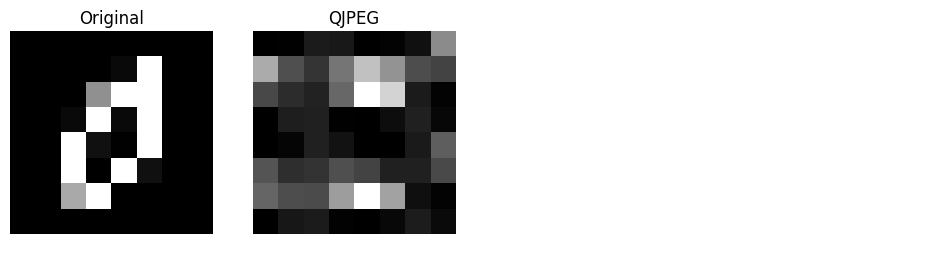

In [28]:
plot_qjpegs(10)

In [32]:
# # plotting kernel heatmaps
# def plot_kernel(K, title):
#     plt.figure(figsize=(5,5))
#     plt.imshow(K, cmap="viridis")
#     plt.colorbar()
#     plt.title(title)
#     plt.xlabel("Samples")
#     plt.ylabel("Samples")
#     plt.show()

# K_test_orig = compute_kernel(states_train, states_test_orig)
# K_test_jpeg = compute_kernel(states_train, states_test_jpeg)
# K_test_up   = compute_kernel(states_train, states_test_upsampled)
# K_test_rt   = compute_kernel(states_train, states_test_roundtrip)

# # normalize using training kernel scale
# K_test_orig /= K_train.max()
# K_test_jpeg /= K_train.max()
# K_test_up   /= K_train.max()
# K_test_rt   /= K_train.max()

# plot_kernel(K_test_orig, "Inference Kernel – Original")
# plot_kernel(K_test_jpeg, "Inference Kernel – QJPEG")
# plot_kernel(K_test_up,   "Inference Kernel – Upsampled")
# plot_kernel(K_test_rt,   "Inference Kernel – Round-trip")